In [1]:
!pip install arabert
!pip install swifter
!pip install accelerate
!pip install transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.2 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186455 sha256=4966668d9ea048290f83a5b9dc9843101446e80b4931194ead1b7672827b3c7f
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.14.1
    Uninstalling emoji-2.14.1:
      Successfully uninstalled emoji-2.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=ca3296a8eacf34fcc749110933b376c8b33219a0a4d4577caa585878c14aff20
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278d

In [18]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from keras.layers import Input, SimpleRNN, Dense, Dropout, LSTM, Bidirectional
from keras.regularizers import l2
import matplotlib.pyplot as plt
# word embedding modules
import transformers
from transformers import BertTokenizer, BertModel
from arabert.preprocess import ArabertPreprocessor
from datasets import Dataset
from tqdm import tqdm
import swifter  
import re

In [4]:
# fetching data
DATA_URL = "/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv"

# Tokenizer model
MODEL_NAME = "aubmindlab/bert-base-arabertv02"

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preprocessing

In [5]:
# search in data
pre_data = pd.read_csv(DATA_URL)
# Printing first 5 rows
pre_data.head()

,label,content
0,1,النعال المريحة: أرتدي هذه النعال كثيرًا!فهي دا...
1,1,منتج جميل ، خدمة سيئة: لقد اشتريت زوجًا من الن...
2,1,جيد للأشياء الصغيرة: هذا يعمل بشكل جيد لالتقاط...
3,0,واهية للغاية: flimsyif للغاية ، فأنت تشتريه ، ...
4,1,Pop for Girls and Girly Boys ، والأشخاص الذين ...


In [6]:
# Df Information
pre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330000 entries, 0 to 329999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   label    330000 non-null  int64 
 1   content  330000 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.0+ MB


In [8]:
pre_data.shape

(330000, 2)

In [9]:
# Check if there are null values
pre_data.isna().sum()

label      0
content    0
dtype: int64

In [10]:
# Duplicated values
pre_data.duplicated().sum()

32

In [11]:
# Duplicate rows
pre_data[pre_data.duplicated()][:5]

,label,content
2389,0,بما فيه الكفاية بالفعل: هذا هو آخر كتاب لي بات...
2398,1,ليس أفضل ما لديها ، ولكن ممتعة: كنت أنتظر ذلك ...
2399,0,ليس جيدًا على الإطلاق: لقد كنت متحمسًا جدًا عن...
12312,0,إن التعليم المسيحي للكنيسة الكاثوليكية يقول كل...
12877,0,لم ترقى إلى مستوى الضجيج: الكثير من الضجيج أحا...


In [12]:
# Remove Duplicates
data = pre_data.drop_duplicates(subset = "content")
data.duplicated().sum()

0

In [13]:
data.shape

(329968, 2)

In [14]:
data["sent_len"] = data["content"].apply(lambda x: len(x.split()))

<ipython-input-14-601c67f810ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sent_len"] = data["content"].apply(lambda x: len(x.split()))


In [15]:
data.head(10)

,label,content,sent_len
0,1,النعال المريحة: أرتدي هذه النعال كثيرًا!فهي دا...,20
1,1,منتج جميل ، خدمة سيئة: لقد اشتريت زوجًا من الن...,72
2,1,جيد للأشياء الصغيرة: هذا يعمل بشكل جيد لالتقاط...,23
3,0,واهية للغاية: flimsyif للغاية ، فأنت تشتريه ، ...,23
4,1,Pop for Girls and Girly Boys ، والأشخاص الذين ...,55
5,1,تم الوفاء بالذكريات: شكرًا على تزويدني بشيء اع...,33
6,1,Love to Love Book of Love: Book of Love هو أحد...,110
7,1,كريستين ، الملاك!: هذا الكتاب هائل!المعلومات ل...,85
8,1,The Everest of Musical Theatre: اليوم ، يُشار ...,93
9,0,عار: لقد شعرت بخيبة أمل لأنه رائحة الدخان وكان...,26


#### **Sorting rows according to their length to see wether there is rows that will not give impact to our models**

In [16]:
data.sort_values("sent_len")

,label,content,sent_len
136694,0,/؟؟؟؟؟؟؟؟؟؟؟؟؟؟,1
287679,1,(+_+).,1
102967,0,هههههههههههههههههههههههههههههههههههههههههههههه...,1
326011,0,؟؟؟؟؟؟؟؟؟؟؟؟؟,1
235231,0,هههههههههههههههههههههههههههههههههههههههههههههه...,1
...,...,...,...
40611,0,ما هو القرص المضغوط الذي تقوم بتصنيفه؟: قبل أن...,189
216559,1,العظمة الأصلية الأمريكية المستقلة: هل تصدق أنن...,190
97419,1,أنا سعيد جدًا لأنني وجدت هذا !!^-^: لقد اشتريت...,197
18128,1,&#1055 ؛ &#1072 ؛ &#1084 ؛ &#1103 ؛ &#1090 ؛ &...,197


### Data Cleaning

In [19]:
# nltk to use corpus
import nltk
from nltk.corpus import stopwords # to remove stopwords
# Preprocessor
preprocessor = ArabertPreprocessor(model_name=MODEL_NAME)
# Preprocessing methods
ar_stopwords = stopwords.words("arabic") # rabic stopwords
PUNCTUATION_REGEX = re.compile(r'[^\w\s]') # Remove punctuation
ENGLISH_REGEX = re.compile(r'[A-Za-z]+')  # Remove English words
NUMBERS_REGEX = re.compile(r'\d+') # Remove numbers
EXTRA_SPACES_REGEX = re.compile(r'\s+') # Remove extra spaces

In [20]:
def clean_text(sent):
    text = preprocessor.preprocess(sent)
    text = PUNCTUATION_REGEX.sub(' ', sent)
    text = ENGLISH_REGEX.sub('', text)
    text = NUMBERS_REGEX.sub('', text)
    text = EXTRA_SPACES_REGEX.sub(' ', text).strip()
    text = " ".join(word for word in text.split() if word not in ar_stopwords)
    return preprocessor.unpreprocess(text)

In [21]:
# test the clean_text func on text before applying it on our data
print(f"Text before cleaning: {data.iloc[1, 1]}", end = "\n")
print(f"Text after cleaning: {clean_text(data.iloc[1, 1])}")

Text before cleaning: منتج جميل ، خدمة سيئة: لقد اشتريت زوجًا من النعال الباو الدب.باتباع إرشادات وصف المنتج ، ارتفعت حجمًا للتناسب.عندما وصلوا ، كانوا لطيفين حقًا وأحبوا.كانت كبيرة جدا.حاولت إعادة ترتيب ولم تكن متوفرة.حاولت الاتصال بـ Claussette عبر الهاتف وقيل لها البريد الإلكتروني.لقد أرسلت عبر البريد الإلكتروني معضلي وانتظرت أسبوعًا ، ولم ترد ، لقد أرسلت رسالتي الإلكترونية مرة أخرى ، قبل ثلاثة أيام.لا يوجد استجابة.أريد فقط استبدال العنصر ، أو الحصول على إجابة.
Text after cleaning: منتج جميل خدمة سيئة لقد اشتريت زوج النعال الباو الدب باتباع إرشادات وصف المنتج ارتفعت حجم للتناسب عندما وصلوا كانوا لطيفين حق وأحبوا كانت كبيرة جدا حاولت إعادة ترتيب ولم تكن متوفرة حاولت الاتصال بـ عبر الهاتف وقيل البريد الإلكتروني لقد أرسلت عبر البريد الإلكتروني معضلي وانتظرت أسبوع ولم ترد لقد أرسلت رسالتي الإلكترونية مرة أخرى أيام يوجد استجابة أريد فقط استبدال العنصر الحصول إجابة


In [22]:
# applying the function on whole data, and store the preprocessed data in new column
data["preproc_content"] = data["content"].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/329968 [00:00<?, ?it/s]

<ipython-input-22-0e61b1d1a698>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["preproc_content"] = data["content"].swifter.apply(clean_text)


In [23]:
# printing first 10 rows
data["preproc_content"].head(10)

0    النعال المريحة أرتدي النعال كثير فهي دافئة ومر...
1    منتج جميل خدمة سيئة لقد اشتريت زوج النعال البا...
2    جيد للأشياء الصغيرة يعمل بشكل جيد لالتقاط قطع ...
3    واهية للغاية للغاية فأنت تشتريه حذر جد للغاية ...
4    والأشخاص يحبون الضحك فقط تبتسم عندما تستمع وهم...
5    تم الوفاء بالذكريات شكر تزويدني بشيء اعتقدت أن...
6    فرقتي المفضلة أواخر الثمانينيات أوائل التسعيني...
7    كريستين الملاك الكتاب هائل المعلومات تنتهي إنه...
8    اليوم شار السير أندرو لويد ويبر أنحاء العالم ب...
9    عار لقد شعرت بخيبة أمل لأنه رائحة الدخان وكانت...
Name: preproc_content, dtype: object

In [24]:
# printing random row to check if our data is correctly preprocessed
print(data.iloc[1, 3])

منتج جميل خدمة سيئة لقد اشتريت زوج النعال الباو الدب باتباع إرشادات وصف المنتج ارتفعت حجم للتناسب عندما وصلوا كانوا لطيفين حق وأحبوا كانت كبيرة جدا حاولت إعادة ترتيب ولم تكن متوفرة حاولت الاتصال بـ عبر الهاتف وقيل البريد الإلكتروني لقد أرسلت عبر البريد الإلكتروني معضلي وانتظرت أسبوع ولم ترد لقد أرسلت رسالتي الإلكترونية مرة أخرى أيام يوجد استجابة أريد فقط استبدال العنصر الحصول إجابة


In [25]:
# making column to compare between the length of text before and after cleaning
data["preproc_sent_len"] = data["preproc_content"].apply(lambda x: len(x.split()))

<ipython-input-25-5829b991d9cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["preproc_sent_len"] = data["preproc_content"].apply(lambda x: len(x.split()))


In [26]:
# comparing texts with each other
data.loc[:, ["sent_len", "preproc_sent_len"]].head(10)

,sent_len,preproc_sent_len
0,20,20
1,72,65
2,23,16
3,23,16
4,55,30
5,33,29
6,110,73
7,85,53
8,93,65
9,26,19


In [27]:
# sorting rows ascendingly according to their length after cleaning
data.sort_values("preproc_sent_len")

,label,content,sent_len,preproc_content,preproc_sent_len
100818,1,por ti por mi: la vida mia ha sido bendecida c...,36,,0
296010,1,es el mejor equipo para medir la presion astia...,37,,0
136694,0,/؟؟؟؟؟؟؟؟؟؟؟؟؟؟,1,,0
295574,1,Muy Buenos Products Para Practicar Ingles: Cre...,32,,0
136383,0,La Perdida del Tiempo: ¿porque en vez de lier ...,33,,0
...,...,...,...,...,...
94397,0,مخيب للآمال للغاية - التصميم الرديء ، مبالغ في...,161,مخيب للآمال للغاية التصميم الرديء مبالغ لقد لد...,122
106754,1,دراسة استقصائية تحليلية مفيدة ، أيقونة: الآن ف...,171,دراسة استقصائية تحليلية مفيدة أيقونة الطبعة ال...,124
75008,1,الكثير من التنوع ، قراءة رائعة ، ملفات تعريف ا...,162,الكثير التنوع قراءة رائعة ملفات تعريف الارتباط...,124
19707,1,أحبها!: عندما وصلت الخيمة ، قررنا إعدادها على ...,156,أحبها عندما وصلت الخيمة قررنا إعدادها الشاحنة ...,125


In [28]:
# fill rows with null values with the orginal text
data["preproc_content"] = data["preproc_content"].fillna(data["content"])

<ipython-input-28-cc2507d41072>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["preproc_content"] = data["preproc_content"].fillna(data["content"])


#### We will calculate the maximum, minimum, average length of the data, and later we will use one of them to make all of the sentences has the same length

In [29]:
max_sent_len = data["preproc_sent_len"].max()
max_sent_len

129

In [30]:
min_sent_len = data["preproc_sent_len"].min()
min_sent_len

0

In [31]:
data[data["preproc_sent_len"] == min_sent_len]

,label,content,sent_len,preproc_content,preproc_sent_len
8132,1,Gooooooood Times!: [...] [...] Wiki Buttholesu...,29,,0
9070,1,Gran Aida.: A Nivel General esta una gran vers...,120,,0
9333,1,LO MAXIMO: ESTE CD ES LO MAXIMO ، DE VERAS QUE...,38,,0
9792,0,لا llena las expectativas: las recetas que inc...,24,,0
12467,1,Maravillosa Historia: Cautivante Fuera de Este...,24,,0
...,...,...,...,...,...
322694,1,WWF: Best of WrestleMania (p101) VHS: Best of ...,45,,0
323117,1,Espectacular !!!: este es uno de los mejores d...,46,,0
326011,0,؟؟؟؟؟؟؟؟؟؟؟؟؟,1,,0
326975,1,The start of an amazing career: AMAZING SOULFU...,28,,0


In [32]:
# rows with 0 characters will be removed as they will not have impact on the model's performance
data = data.drop(data[data["preproc_sent_len"] == min_sent_len].index)

In [33]:
avg_sent_len = np.round(data["preproc_sent_len"].mean())
avg_sent_len

43.0

### Data Distribution

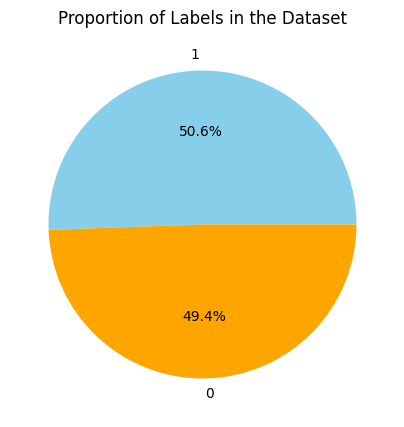

In [31]:
data["label"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["skyblue", "orange"], figsize=(5, 5))
plt.title("Proportion of Labels in the Dataset")
plt.ylabel("")

plt.show()

### Word Embeddings for Deep Neural Networks

In [142]:
# defining embedding model and tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
emd_model = BertModel.from_pretrained(MODEL_NAME)

In [43]:
# Define optimized batch size
BATCH_SIZE = 28 

# Convert preprocessed sentences to a list
text = data["preproc_content"].tolist()
labels = data["label"].tolist()

# DataLoader with optimized settings
data_loader = DataLoader(text, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [48]:
emd_model.eval()
emd_model.to(device, non_blocking=True)

embeddings = []  # List to store embeddings
max_len = max_sent_len

def tokenize_batch(batch):
    return tokenizer(batch, padding="max_length", max_length=max_len, truncation=True, return_tensors="pt")

with torch.no_grad():
    for batch in tqdm(data_loader, desc="Processing batches", ncols=100):
        inputs = tokenize_batch(batch)
        inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}  # Move inputs to GPU

        # Extracting CLS token
        cls_embeddings = emd_model(**inputs).last_hidden_state[:, 0, :]  # CLS token

        # Move embeddings to CPU and then we store it
        embeddings.append(cls_embeddings.cpu().numpy())

        # Delete tensors and clear cache to avoid consuming all the gpu or cpu resources
        del inputs, cls_embeddings
        torch.cuda.empty_cache() 

print("CLS token extraction complete!")

Processing batches: 100%|█████████████████████████████████████| 11779/11779 [45:04<00:00,  4.36it/s]

CLS token extraction complete!


In [49]:
# Convert to NumPy
embeddings = np.concatenate(embeddings, axis=0)
embeddings

array([[-0.9396442 , -1.1223081 , -0.30688322, ...,  0.69435424,
        -0.50888395,  0.14992289],
       [-0.46583736, -0.56254846, -0.60762036, ...,  1.1610957 ,
        -0.56663823,  0.86108094],
       [-1.0575266 , -1.0644412 , -0.94989663, ...,  0.84310627,
        -0.69104856,  1.0305452 ],
       ...,
       [ 0.50682825, -0.6102133 , -0.7685557 , ...,  1.3972441 ,
        -0.26164353,  0.65368223],
       [-0.93577427, -0.68862975, -0.17425203, ...,  1.2338207 ,
         0.15018323,  0.55830973],
       [-0.540434  , -1.8966914 , -0.30485794, ...,  1.1511852 ,
         0.460621  ,  1.1234028 ]], dtype=float32)

In [68]:
print(f"Original embeddings shape: {embeddings.shape}")  # Expected: (num_samples, 768)


Original embeddings shape: (329799, 768)


#  DL Models Architecure & Data Preparation

In [50]:
def plot_metric(history, metric = "accuracy"):
    plt.plot(history.history[metric],color= "b",label=f"Training {metric}")
    plt.plot(history.history[f"val_{metric}"],color="r",label=f"Validation {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.upper())
    plt.legend(loc='lower right')
    plt.title(f"Training and Test {metric} Graph")
    plt.show()

In [51]:
def RNN():
    model = keras.models.Sequential([
    # Input layer
    Input(shape=(sent_len, EMBEDDING_DIM)), # Max Number of words in each sequence x Embedding Dimension
    # RNN layer
    SimpleRNN(128, return_sequences = True, activation = "relu"), # Pass outputs to next RNN layer
    SimpleRNN(128, return_sequences = False, activation = "relu"), # Pass outputs to next RNN layer
    # Fully connected layers
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    # Drop out 15% of neurons
    Dropout(0.2),
    # Output layer
    Dense(1, activation='sigmoid')
])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [52]:
def bi_RNN():
    model = keras.models.Sequential([
    # Input layer
    Input(shape=(sent_len, EMBEDDING_DIM)), # Max Number of words in each sequence x Embedding Dimension
    # RNN layer
    keras.layers.Bidirectional(SimpleRNN(64, kernel_regularizer = l2(0.01), activation = "relu")),
    # Fully connected layers
    Dense(32, activation = 'relu', kernel_regularizer = l2(0.01)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(0.01)),
    Dense(32, activation = 'relu'),
    # Output layer
    Dense(1, activation='sigmoid')
])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [85]:
def lstm():
    model = keras.Sequential([
    Input(shape=(sent_len, EMBEDDING_DIM)),
    LSTM(64, return_sequences = True),
    LSTM(64, return_sequences = False),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dropout(0.15),
    Dense(1, activation='sigmoid')
])
    
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [54]:
def bi_lstm():
    model = keras.Sequential([
    Input(shape=(sent_len, EMBEDDING_DIM)),
    keras.layers.Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
    
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

## Training 

In [44]:
TEST_SIZE = 0.3
BATCH_SIZE_T = 32
EPOCHS = 10
sent_len = 1
labels = np.array(labels)
EMBEDDING_DIM = embeddings.shape[1]

In [76]:
x_train, x_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=TEST_SIZE, random_state = 340
    )

In [77]:
# Reshape to (batch_size, sequence_length=1, embedding_dim)
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])  # (230859, 1, 768)
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])      # (test_size, 1, 768)

In [78]:
x_train.shape

(230859, 1, 768)

### RNN Model 

Epoch 1/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8245 - loss: 0.3901 - val_accuracy: 0.8383 - val_loss: 0.3673
Epoch 2/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8494 - loss: 0.3448 - val_accuracy: 0.8477 - val_loss: 0.3482
Epoch 3/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8545 - loss: 0.3348 - val_accuracy: 0.8492 - val_loss: 0.3389
Epoch 4/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8558 - loss: 0.3315 - val_accuracy: 0.8543 - val_loss: 0.3327
Epoch 5/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8600 - loss: 0.3255 - val_accuracy: 0.8553 - val_loss: 0.3326
Epoch 6/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8612 - loss: 0.3223 - val_accuracy: 0.8554 - val_loss: 0.3304
Epoch 7/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8612 - loss: 0.3207 - val_accuracy: 0.8553 - val_loss: 0.3306
Epoch 8/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8629 - loss: 0

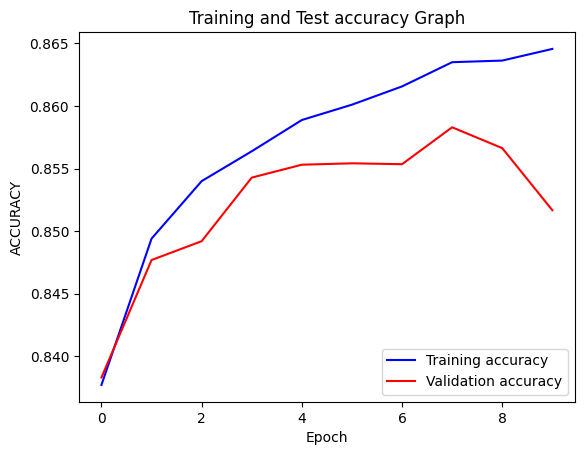

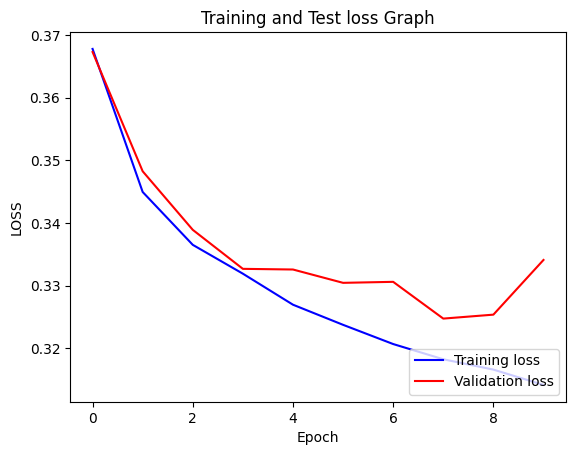

In [80]:
# RNN model
rnn_model = RNN()

# train
history = rnn_model.fit(x_train, y_train, epochs = EPOCHS , validation_data=(x_test,y_test), batch_size = BATCH_SIZE_T)
loss, acc = rnn_model.evaluate(x_test,  y_test, verbose=2)

# Plot Accuracy
plot_metric(history, "accuracy")

# # Plot Loss
plot_metric(history, "loss")

Epoch 1/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.8185 - loss: 0.6376 - val_accuracy: 0.8396 - val_loss: 0.3972
Epoch 2/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8348 - loss: 0.3997 - val_accuracy: 0.8124 - val_loss: 0.4475
Epoch 3/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8368 - loss: 0.3908 - val_accuracy: 0.8393 - val_loss: 0.3836
Epoch 4/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8380 - loss: 0.3869 - val_accuracy: 0.8400 - val_loss: 0.3833
Epoch 5/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8386 - loss: 0.3860 - val_accuracy: 0.8302 - val_loss: 0.4038
Epoch 6/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8387 - loss: 0.3854 - val_accuracy: 0.8401 - val_loss: 0.3823
Epoch 7/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8365 - loss: 0.3882 - val_accuracy: 0.8438 - val_loss: 0.3780
Epoch 8/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.8379 - loss: 0

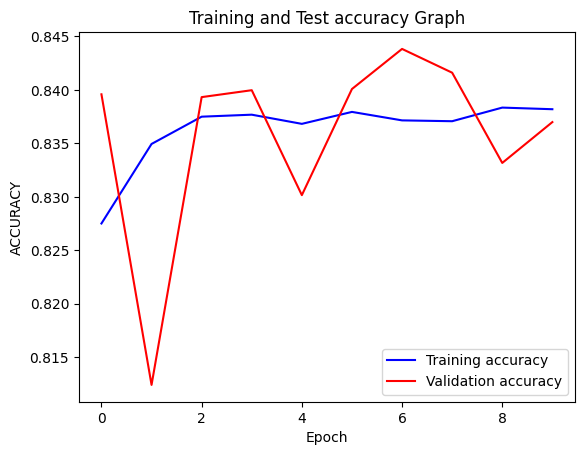

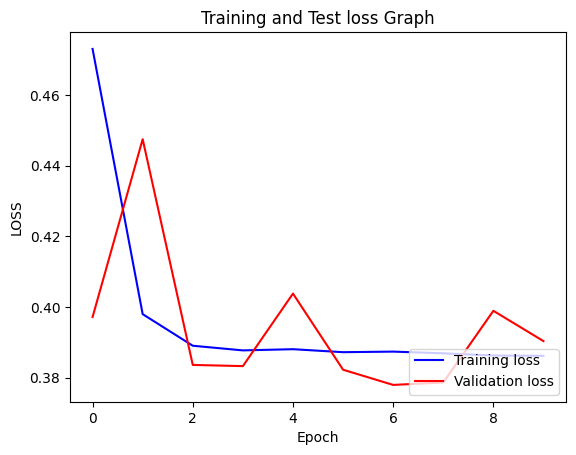

In [81]:
bi_rnn_model = bi_RNN()
# train
history = bi_rnn_model.fit(x_train, y_train, epochs = EPOCHS , validation_data=(x_test,y_test), batch_size = BATCH_SIZE_T)
loss, acc = bi_rnn_model.evaluate(x_test,  y_test, verbose=2)

# Plot Accuracy
plot_metric(history, "accuracy")

# Plot Loss
plot_metric(history, "loss")

Epoch 1/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.8246 - loss: 0.3982 - val_accuracy: 0.8469 - val_loss: 0.3502
Epoch 2/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.8461 - loss: 0.3550 - val_accuracy: 0.8364 - val_loss: 0.3742
Epoch 3/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.8493 - loss: 0.3473 - val_accuracy: 0.8494 - val_loss: 0.3438
Epoch 4/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.8533 - loss: 0.3403 - val_accuracy: 0.8492 - val_loss: 0.3417
Epoch 5/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.8540 - loss: 0.3369 - val_accuracy: 0.8536 - val_loss: 0.3375
Epoch 6/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.8574 - loss: 0.3323 - val_accuracy: 0.8459 - val_loss: 0.3523
Epoch 7/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.8567 - loss: 0.3318 - val_accuracy: 0.8529 - val_loss: 0.3381
Epoch 8/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.8595 - loss: 0

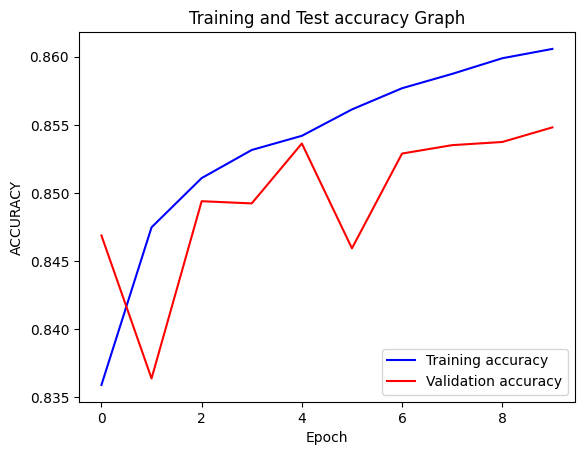

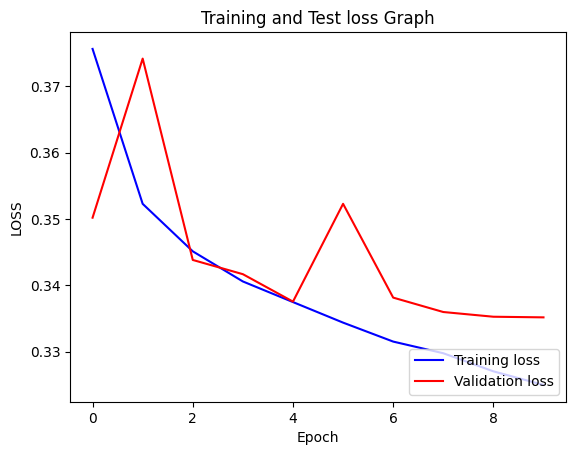

In [87]:
lstm_model = lstm()
history = lstm_model.fit(x_train, y_train, epochs = EPOCHS , validation_data=(x_test,y_test), batch_size = BATCH_SIZE_T)
loss, acc = lstm_model.evaluate(x_test,  y_test, verbose=2)

# Plot Accuracy
plot_metric(history, "accuracy")

# Plot Loss
plot_metric(history, "loss")

Epoch 1/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.8263 - loss: 0.3865 - val_accuracy: 0.8487 - val_loss: 0.3438
Epoch 2/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.8565 - loss: 0.3304 - val_accuracy: 0.8480 - val_loss: 0.3423
Epoch 6/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.8584 - loss: 0.3261 - val_accuracy: 0.8534 - val_loss: 0.3339
Epoch 7/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.8602 - loss: 0.3201 - val_accuracy: 0.8542 - val_loss: 0.3332
Epoch 10/10
7215/7215 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.8615 - loss: 0.3189 - val_accuracy: 0.8523 - val_loss: 0.3364
3092/3092 - 6s - 2ms/step - accuracy: 0.8523 - loss: 0.3364


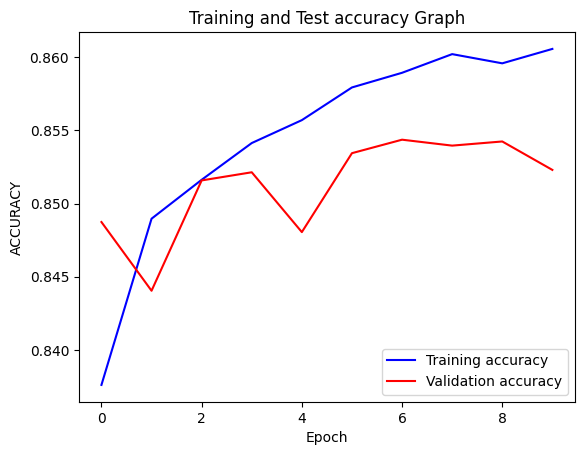

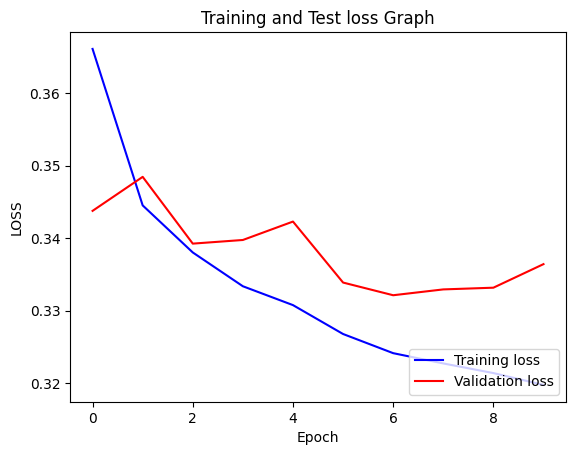

In [89]:
bi_lstm_model = bi_lstm()
# train
history = bi_lstm_model.fit(x_train, y_train, epochs = EPOCHS , validation_data=(x_test,y_test), batch_size = BATCH_SIZE_T)
loss, acc = bi_lstm_model.evaluate(x_test,  y_test, verbose=2)

# Plot Accuracy
plot_metric(history, "accuracy")

# Plot Loss
plot_metric(history, "loss")

### Evaluation on test texts

In [106]:
# Define test examples
test_examples = [
    "أنا سعيد جدًا اليوم، كل شيء يسير على ما يرام!",
    "هذا أسوأ يوم في حياتي، كل شيء سيء للغاية.",
    "هذا الممثل يقوم بأدوار رائعة ولكنه لم يؤدي بشكل جيد مثلما كان يفعلو أتمنى أن يعود الى رشده"
]

In [99]:
def predict(model, sentences):
    encodings = tokenizer(
    sentences,
    padding="max_length",
    max_length=max_sent_len,
    truncation=True,
    return_tensors="pt"
)

    inputs = {key: tensor.to(device) for key, tensor in encodings.items()}
    
    # Extract CLS token embeddings
    with torch.no_grad():
        embeddings = emd_model(**inputs).last_hidden_state[:, 0, :].cpu().numpy()

    embeddings_reshaped = embeddings.reshape(embeddings.shape[0], 1, embeddings.shape[1])

    # Predict sentiment
    predictions = model.predict(embeddings_reshaped)
    sentiment_labels = ["Positive" if pred > 0.5 else "Negative" for pred in predictions]

    # Print results
    for i, sentence in enumerate(sentences):
        print(f"Sentence: {sentence}\nPredicted Sentiment: {sentiment_labels[i]}\n")

In [118]:
# Using RNN Model
predict(rnn_model, test_examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sentence: أنا سعيد جدًا اليوم، كل شيء يسير على ما يرام!
Predicted Sentiment: Positive

Sentence: هذا أسوأ يوم في حياتي، كل شيء سيء للغاية.
Predicted Sentiment: Negative

Sentence: هذا الممثل يقوم بأدوار رائعة ولكنه لم يؤدي بشكل جيد مثلما كان يفعلو أتمنى أن يعود الى رشده
Predicted Sentiment: Negative



In [119]:
# Using LSTM model
predict(lstm_model, test_examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sentence: أنا سعيد جدًا اليوم، كل شيء يسير على ما يرام!
Predicted Sentiment: Positive

Sentence: هذا أسوأ يوم في حياتي، كل شيء سيء للغاية.
Predicted Sentiment: Negative

Sentence: هذا الممثل يقوم بأدوار رائعة ولكنه لم يؤدي بشكل جيد مثلما كان يفعلو أتمنى أن يعود الى رشده
Predicted Sentiment: Negative



In [120]:
# Using BI_RNN model
predict(bi_rnn_model, test_examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sentence: أنا سعيد جدًا اليوم، كل شيء يسير على ما يرام!
Predicted Sentiment: Positive

Sentence: هذا أسوأ يوم في حياتي، كل شيء سيء للغاية.
Predicted Sentiment: Negative

Sentence: هذا الممثل يقوم بأدوار رائعة ولكنه لم يؤدي بشكل جيد مثلما كان يفعلو أتمنى أن يعود الى رشده
Predicted Sentiment: Negative



In [121]:
# Using BI_LSTM model
predict(bi_lstm_model, test_examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sentence: أنا سعيد جدًا اليوم، كل شيء يسير على ما يرام!
Predicted Sentiment: Positive

Sentence: هذا أسوأ يوم في حياتي، كل شيء سيء للغاية.
Predicted Sentiment: Negative

Sentence: هذا الممثل يقوم بأدوار رائعة ولكنه لم يؤدي بشكل جيد مثلما كان يفعلو أتمنى أن يعود الى رشده
Predicted Sentiment: Negative



# Fine-tuning GPT Model

In [37]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, AdamW

## tokenization

First we will tokenize text data by using GPT2Tokenizer to return input_id,attention_mask and the target label(0 or 1)

In [39]:
# Load GPT2 tokenizer
gpt_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
gpt_tokenizer.pad_token_id = gpt_tokenizer.eos_token_id

In [40]:
def tokenize_function(examples):
    return gpt_tokenizer(examples["preproc_content"], padding="max_length", truncation=True, max_length = max_sent_len)

#### *We need to split our data into train (70%) and test dataset (30%), so we need to split the original dataframe first (we'll not use the previous text, labels variables as they are list and not compatible with transformer GPT2 model) then we'll use Dataset to convert into dataset (compatible with transformers GPT2 model)*

In [45]:
# Split dataset into train and test
train,test= train_test_split(data, test_size=TEST_SIZE, random_state=42)

# converting pandas dataframe into dataset suitable for transformers
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

In [46]:
# info about training and testing dataset
print(f"Training Dataset info: {train_dataset}")
print(f"Test Dataset info: {test_dataset}")

Training Dataset info: Dataset({
    features: ['label', 'content', 'sent_len', 'preproc_content', 'preproc_sent_len', '__index_level_0__'],
    num_rows: 230859
})
Test Dataset info: Dataset({
    features: ['label', 'content', 'sent_len', 'preproc_content', 'preproc_sent_len', '__index_level_0__'],
    num_rows: 98940
})


In [47]:
train_token_dataset = train_dataset.map(tokenize_function, batched=True)
test_token_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/230859 [00:00<?, ? examples/s]

Map:   0%|          | 0/98940 [00:00<?, ? examples/s]

In [48]:
print(train_token_dataset[0])

{'label': 0, 'content': 'ليس مفيدًا للغاية: هذا الكتاب لا يعلمك أي شيء عن QuickBooks التي لم تتمكن من العثور عليها في ملفات المساعدة.لا توجد نصائح أو حيل خاصة لمساعدتك في إعداد واستخدام QuickBooks بكفاءة.لقد عدت إليها ، وللأسعار نفسها ، اشتريت دليل QuickBooks الرسمي من قبل Ivens.مثلما مثال على فشله ، لم أتمكن من معرفة كيفية إعداد مدفوعات ضريبة المبيعات لعملي ، ولم يكن للدليل المفقود أي معلومات حول هذا الموضوع المعقد (في ولايتي ، يتعين على الشركات الإبلاغ عن مقاطعة كل-على حدة-أساس المقاطعة ، مع معدلات مختلفة للعديد من المقاطعات).لقد مرّي الدليل الرسمي بكل الخطوات ، بوضوح شديد ، مما يجعل الأمر سهلاً للغاية.', 'sent_len': 102, 'preproc_content': 'مفيد للغاية الكتاب يعلمك شيء تتمكن العثور عليها ملفات المساعدة توجد نصائح حيل لمساعدتك إعداد واستخدام بكفاءة لقد عدت إليها وللأسعار نفسها اشتريت دليل الرسمي مثلما مثال فشله أتمكن معرفة كيفية إعداد مدفوعات ضريبة المبيعات لعملي ولم يكن للدليل المفقود معلومات حول الموضوع المعقد ولايتي يتعين الشركات الإبلاغ مقاطعة حدة أساس المقاطعة معدلات مختلفة للعد

In [52]:
# train and test datasets after tokenization
print(f"Train dataset after tokenization: {train_token_dataset}")
print(f"Test dataset after tokenization: {test_token_dataset}")

Train dataset after tokenization: Dataset({
    features: ['label', 'content', 'sent_len', 'preproc_content', 'preproc_sent_len', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 230859
})
Test dataset after tokenization: Dataset({
    features: ['label', 'content', 'sent_len', 'preproc_content', 'preproc_sent_len', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 98940
})


#### *For the sake of optimizing memory usage and debugging and making the datasets compatible with the model and easily tracking the process, we will convert the column values into pytorch tensor, and remove the unwanted features (only keeping the important ones)*

In [61]:
# making datasets consistent and keep only important features that will be fed up to the GPT model
train_token_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_token_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [63]:
# to make sure of what we did
print(f"datasets after reformatting: {train_token_dataset[0]}")

datasets after reformatting: {'label': tensor(0), 'input_ids': tensor([25405,   149,   223, 22654, 38843,   220, 13862, 13862,   148,   118,
        12919, 22654, 45632, 28981,   149,   225, 41486, 34247,   101, 18923,
          232, 44690, 13862, 25405,   149,   225, 17550,   112, 22654,   148,
           94, 17550,   103, 41486, 25405,   149,   225, 23338, 28981, 44690,
          148,   104, 30335, 26897, 17550,   117, 13862, 22654, 29519, 12919,
        47048, 13862,   149,   223, 34247,   103, 28981, 25405, 45692, 34247,
          117, 38843, 45632, 17550,   103, 30335,   148,   105, 38843, 18923,
          228,   148,   113, 34247,    99,   148,   255, 17550,   255, 22654,
        13862,   220, 13862, 25405, 45692, 34247,   117, 38843, 41486,   149,
          225, 17550,    98, 44690, 38843, 34247,   107, 42092, 34247,   111,
        41486,   148,   106, 38843, 12919, 25405, 17550,   101,   149,   225,
          149,   223, 34247,    94, 45632,   220, 13862,   149,   224, 38843,
 

## Passing the parameters to GPT2 Model

Now we are ready to initialize GPT-2 Model for Sequence Classification to predict whether the sentence is positive or negative

In [73]:
# defining gpt model
gpt_model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
gpt_model.config.pad_token_id = gpt_tokenizer.pad_token_id # batch size padding added to the model
gpt_model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [100]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     learning_rate=2e-5,
#     per_device_train_batch_size=32,
#     num_train_epochs=3,
#     weight_decay=0.01,
# )

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=36,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    optim='adamw_torch',
    logging_dir='./logs',
    logging_steps=200,  # we will log the results after processing 200 text
    fp16=True,  
    report_to="none" 
)


# number of training steps to use tqdm and define the progress bar
num_training_steps = len(train_token_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
progress_bar = tqdm(total=num_training_steps, desc="Training Progress")

Training Progress:   0%|          | 0/12824 [1:08:12<?, ?it/s]


In [101]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) 
    acc = accuracy_score(labels, predictions) 
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

trainer = Trainer(
    model=gpt_model,
    args=training_args,
    train_dataset=train_token_dataset,
    eval_dataset=test_token_dataset,
    compute_metrics=compute_metrics
)


In [102]:
trainer.train()

progress_bar.update(num_training_steps)  
progress_bar.close()

print("Training Complete!")

OSError: [Errno 28] No space left on device: './results/checkpoint-6413'

In [ ]:
# Test data evaluation
eval_test = trainer.evaluate() 

#### finally we test the fine tuned model on some sentences

In [111]:
def gpt_sentiment(sentences):
    # Tokenize all sentences
    inputs = gpt_tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(device)
    
    # Get model predictions
    with torch.no_grad():
        outputs = gpt_model(**inputs)

    predictions = outputs.logits.argmax(dim=-1).tolist()
    
    # Convert predictions to class labels (0 = negative, 1 = positive)
    sentiment_labels = ["positive" if pred == 1 else "negative" for pred in predictions]

    # Print results
    for i, sentence in enumerate(sentences):
        print(f"Sentence: {sentence}\nPredicted Sentiment: {sentiment_labels[i]}\n")


gpt_sentiment(test_examples)

Sentence: أنا سعيد جدًا اليوم، كل شيء يسير على ما يرام!
Predicted Sentiment: positive

Sentence: هذا أسوأ يوم في حياتي، كل شيء سيء للغاية.
Predicted Sentiment: negative

Sentence: هذا الممثل يقوم بأدوار رائعة ولكنه لم يؤدي بشكل جيد مثلما كان يفعلو أتمنى أن يعود الى رشده
Predicted Sentiment: negative

